In [ ]:
!pip install pingouin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 9.6 MB/s eta 0:00:00


In [ ]:
!pip -q install fuzzywuzzy

In [ ]:
import pandas as pd
import json
from os.path import join
import os
import pingouin as pg
from tqdm.notebook import tqdm
from fuzzywuzzy import fuzz
import numpy as np
import matplotlib.pyplot as plt

RAW_DATA_PATH = '/content/drive/MyDrive/1 PhD/OverconfidenceLLM/precision/data'
DATA_PATH = "/content/drive/MyDrive/1 PhD/OverconfidenceLLM/precision/outputs"
FIG_SAVE = '/content/drive/MyDrive/1 PhD/OverconfidenceLLM/precision/outputs/figures'

/usr/local/lib/python3.11/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Utils

In [ ]:
def read_json(data_path):
    with open(data_path, 'r') as file:
        data = json.load(file)
    return data

def write_json(data_path, data):
    with open(data_path, 'w') as f:
        json.dump(data, f)

def read_txt(txt_path):
    f = open(txt_path, "r")
    return f.read()

def write_json_lines(file_name,dict_data):
    json_string = json.dumps(dict_data)
    with open(file_name, 'a') as f:
        f.write(json_string+"\n")

def read_json_lines(file_name):
    lines = []
    with open(file_name) as file_in:
        for line in file_in:
            try:
                lines.append(json.loads(line))
            except:
                continue
    return lines

def save_dict_list(file_name, dicts_data):
    for dict_data in dicts_data:
        write_json_lines(file_name,dict_data)

## Data Stats

In [ ]:
def get_data(data_name, model_name, ci_explain, cot):
    file_path = join(DATA_PATH, 'clean|{}|{}|{}|{}.jsonl'.format(data_name, model_name, str(ci_explain), str(cot)))
    data_df = read_json_lines(file_path)
    return data_df

def get_raw_data_stats(data_name):
    df_ = pd.read_csv(join(RAW_DATA_PATH, data_name+'.csv'))
    df_ = df_[df_["final_answer_raw_numerical"]]
    df_['final_answer'] = pd.to_numeric(df_['final_answer'])
    gen_stats = {}
    gen_stats['nquestions'] = df_.shape[0]
    gen_stats['mean'] = df_['final_answer'].mean()
    # gen_stats['std'] = df_['final_answer'].std()
    gen_stats['min'] = df_['final_answer'].min()
    gen_stats['max'] = df_['final_answer'].max()
    return gen_stats

def get_all_stats():
    all_stats = []
    for dataset in ['finqa', 'mmlu', 'medmcqa_medqa']:
        data_stats = get_raw_data_stats(data_name = dataset)
        data_stats['dataset'] = dataset
        all_stats.append(data_stats)
    return pd.DataFrame(all_stats)


In [ ]:
get_all_stats()

,nquestions,mean,min,max,dataset
0,3262,1.109158e+08,-2.094000e+09,8.096800e+10,finqa
1,1606,1.222001e+10,-1.280000e+02,9.789264e+12,mmlu
2,2058,4.033667e+03,-1.000000e+02,6.123457e+06,medmcqa_medqa


In [ ]:
# DATA_NAME = 'mmlu'
# MODEL_NAME = 'gpt-3.5-turbo'

# test_data = get_data(data_name = DATA_NAME, model_name = MODEL_NAME, ci_explain = True, cot = True)

In [ ]:
# collx = ['id', 'confidence_pct', 'conf_prompt_type', 'hint_type', 'try',
#        'data_name', 'model_name', 'ci_exaplain', 'cot', 'question', 'answer',
#        'full_output', 'lower_bound', 'upper_bound', 'length', 'hit']

In [ ]:
# test_data_df = pd.DataFrame(test_data)

In [ ]:
# test_data_df.columns

In [ ]:
# list(test_data_df['full_output'])

In [ ]:
# test_data_df = process_data(test_data_df)

In [ ]:
# test_data_df[test_data_df['hint_type'] == 'hint0'][collx].shape

In [ ]:
# test_data_df[test_data_df['hint_type'] == 'hint0'][collx].dropna().shape

In [ ]:
# test_data_df[test_data_df['hint_type'] == 'hint0'][collx].dropna().shape

In [ ]:
# test_data_norm = normalize_cols(test_data)

In [ ]:
# len(test_data_norm)

In [ ]:
# test_data_norm_df = pd.DataFrame(test_data_norm)

In [ ]:
# test_data_norm_df.shape

In [ ]:
# test_data_norm_df.columns

In [ ]:
# test_data_norm_df = process_data(test_data_norm_df)

In [ ]:
# test_data_norm_df.head()

In [ ]:
# test_data_norm_df[test_data_norm_df['hint_type'] == 'hint0'][collx].dropna().shape

## Measures

In [ ]:
def upload_data(data_name, model_name, ci_explain, cot):
    file_path = join(DATA_PATH, 'clean|{}|{}|{}|{}.jsonl'.format(data_name, model_name, str(ci_explain), str(cot)))
    # else:
    #     file_path = join(DATA_PATH, 'rank|{}|{}|{}|{}.jsonl'.format(data_name, model_name, str(ci_explain), str(cot)))
    if os.path.exists(file_path):
        data_df = pd.DataFrame(read_json_lines(file_path))
        return data_df
    else:
        return None

def process_data(df):
    df_ = df.copy()
    df_['lower_bound'] = pd.to_numeric(df_['lower_bound'], errors='coerce') # df_['lower_bound'].astype(float)
    df_['upper_bound'] = pd.to_numeric(df_['upper_bound'], errors='coerce') # df_['upper_bound'].astype(float)
    df_['answer'] = pd.to_numeric(df_['answer'], errors='coerce')# df_['answer'].astype(float)
    df_['length'] = df_['upper_bound'] - df_['lower_bound']
    df_['hit'] = (df_['upper_bound']>= df_['answer']) & (df_['lower_bound'] <= df_['answer'])
    return df_

def get_general_stats(df):
    all_res = {}
    all_hit_pct = df[df['hit']].shape[0]/df.shape[0]
    all_res['all_hits'] = all_hit_pct
    for confs in list(df['confidence_pct'].unique()):
        hit_pct = df[df['hit'] & (df['confidence_pct'] == confs)].shape[0]/df[df['confidence_pct'] == confs].shape[0]
        all_res['hits|conf:{}'.format(confs)] = hit_pct
    corr_res = pg.corr(x=df['confidence_pct'], y=df['length'])
    corr_res = corr_res.to_dict('records')[0]
    corr_res = {'lconf_corr_'+k:v for k, v in corr_res.items() if k in ['n', 'r', 'p-val']}
    all_res.update(corr_res)
    # all_res['len_corr'] = corr_res['r']
    return all_res

def length_vs_scale(df):
    all_res = {}
    all_res['len_scale_corr'] = pg.corr(x=df['answer'], y=df['length'])
    return all_res


def get_all_gen_stats():

    all_data = []
    coll = ['id', 'confidence_pct', 'conf_prompt_type', 'hint_type', 'try',
       'data_name', 'model_name', 'ci_exaplain', 'cot', 'question', 'answer',
       'full_output', 'lower_bound', 'upper_bound', 'length', 'hit']
    for data_name in tqdm(['finqa', 'mmlu', 'medmcqa_medqa']):
        for cot in tqdm([True, False], leave=False):
            for model_name in tqdm(['gpt-4o-mini', 'gpt-3.5-turbo'], leave=False): #
                data_df = upload_data(data_name = data_name, model_name = model_name, ci_explain = True, cot = cot)
                if data_df is None:
                    continue
                data_pro_df = process_data(df = data_df)
                data_pro_df = data_pro_df.drop_duplicates(subset = ['id', 'confidence_pct', 'conf_prompt_type', 'hint_type', 'try', 'data_name', 'model_name', 'ci_exaplain', 'cot'])
                data_pro_df = data_pro_df[coll]
                # return data_pro_df
                for hint in tqdm(list(data_pro_df['hint_type'].unique()), leave=False):
                    for ii in tqdm(range(10), leave=False):
                        data_grp = data_pro_df[data_pro_df['hint_type'] == hint].groupby(['id', 'confidence_pct', 'data_name', 'model_name', 'cot']).sample(1)
                        hint_stats = get_general_stats(data_grp)
                        # return hint_stats
                        hint_stats['cot'] = cot
                        hint_stats['data_name'] = data_name
                        hint_stats['hint'] = hint
                        hint_stats['model_name'] = model_name
                        hint_stats['num_count'] = data_grp[data_grp['hint_type'] == hint].shape[0]
                        hint_stats['nona_num_count'] = data_grp[data_grp['hint_type'] == hint].dropna().shape[0]
                        all_data.append(hint_stats)
    return pd.DataFrame(all_data)

def format_final_results(res_df):
    col_map = {
        "all_hits": 'hits-avg', 'hits|conf:95': 'hits@95%', 'hits|conf:90': 'hits@90%',
        'hits|conf:60': 'hits@60%', 'hits|conf:70': 'hits@70%', 'hits|conf:80': 'hits@80%',
        'lconf_corr_r': 'corr', 'hint': 'hint', 'data_name': 'dataset', 'model_name': 'model', 'cot': 'cot'
    }
    res_df = res_df[list(col_map.keys())]
    res_df = res_df.rename(columns= col_map)
    fin_res = res_df[res_df['hint'] =='hint0'].groupby(['dataset', 'model', 'cot']).agg({
        "hits-avg": [np.mean, np.std], "hits@95%": [np.mean, np.std], "hits@90%": [np.mean, np.std], "hits@60%": [np.mean, np.std],
        "hits@70%": [np.mean, np.std], "hits@80%": [np.mean, np.std], "corr": [np.mean, np.std]
    })
    for col in list(fin_res.columns):
        if 'hits' in col[0]:
            fin_res[col] = fin_res[col].apply(lambda x: round(x, 4))*100
        else:
            fin_res[col] = fin_res[col].apply(lambda x: round(x, 4))

    return fin_res

def format_final_results_hints(res_df):
    col_map = {
        "all_hits": 'hit-avg', 'hits|conf:95': 'hit@95%', 'hits|conf:90': 'hit@90%',
        'hits|conf:60': 'hit@60%', 'hits|conf:70': 'hit@70%', 'hits|conf:80': 'hit@80%',
        'lconf_corr_r': 'corr', 'hint': 'hint', 'data_name': 'dataset', 'model_name': 'model', 'cot': 'cot'
    }
    res_df = res_df[list(col_map.keys())]
    res_df = res_df.rename(columns= col_map)
    fin_res = res_df[res_df['hint'] !='hint0'].groupby(['model', 'dataset', 'hint', 'cot']).agg({
        "hit-avg": [np.mean, np.std], "hit@95%": [np.mean, np.std], "hit@90%": [np.mean, np.std], "hit@60%": [np.mean, np.std],
        "hit@70%": [np.mean, np.std], "hit@80%": [np.mean, np.std], "corr": [np.mean, np.std]
    })

    def use_f_2(num_decimals):
        def use_f_2_(x):
            return f"%.{num_decimals}f" % x
        return use_f_2_

    latex_format = {}
    for col in list(fin_res.columns):
        if 'hit' in col[0]:
            fin_res[col] = fin_res[col].apply(lambda x: round(x, 4))*100
            latex_format[col] = use_f_2(num_decimals = 2)
        else:
            fin_res[col] = fin_res[col].apply(lambda x: round(x, 4))
            latex_format[col] = use_f_2(num_decimals = 4)
    fin_res_latex = fin_res.to_latex(formatters=latex_format)
    return fin_res, fin_res_latex



## General Stats

In [ ]:
all_stats = get_all_gen_stats()

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
all_stats.shape

(480, 15)

In [ ]:
# all_stats[coll].shape

In [ ]:
# all_stats[coll].dropna().shape

In [ ]:
# all_stats.columns

In [ ]:
# all_stats.columns

In [ ]:
# all_stats

### No Hint

In [ ]:
vv = format_final_results(res_df = all_stats)

<ipython-input-25-34f7725be371>:78: FutureWarning: The provided callable <function mean at 0x7fb1023993a0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  fin_res = res_df[res_df['hint'] =='hint0'].groupby(['dataset', 'model', 'cot']).agg({
<ipython-input-25-34f7725be371>:78: FutureWarning: The provided callable <function std at 0x7fb1023994e0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  fin_res = res_df[res_df['hint'] =='hint0'].groupby(['dataset', 'model', 'cot']).agg({
<ipython-input-25-34f7725be371>:78: FutureWarning: The provided callable <function mean at 0x7fb1023993a0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean"

In [ ]:
vv.columns

MultiIndex([('hits-avg', 'mean'),
            ('hits-avg',  'std'),
            ('hits@95%', 'mean'),
            ('hits@95%',  'std'),
            ('hits@90%', 'mean'),
            ('hits@90%',  'std'),
            ('hits@60%', 'mean'),
            ('hits@60%',  'std'),
            ('hits@70%', 'mean'),
            ('hits@70%',  'std'),
            ('hits@80%', 'mean'),
            ('hits@80%',  'std'),
            (    'corr', 'mean'),
            (    'corr',  'std')],
           )

In [ ]:
vv

hits-avg       hits@95%       hits@90%  \
                                      mean   std     mean   std     mean   
dataset       model         cot                                            
finqa         gpt-3.5-turbo False     6.50  0.16     6.16  0.36     5.73   
                            True      7.27  0.10     7.00  0.23     7.03   
              gpt-4o-mini   False    18.33  0.09    21.16  0.45    18.73   
                            True     20.37  0.24    21.53  0.53    20.47   
medmcqa_medqa gpt-3.5-turbo False    48.13  0.24    48.35  0.70    47.89   
                            True     48.80  0.37    49.07  0.96    48.11   
              gpt-4o-mini   False    60.34  0.21    60.68  0.40    60.22   
                            True     67.40  0.30    68.42  0.53    67.81   
mmlu          gpt-3.5-turbo False    59.31  0.29    59.36  1.03    58.86   
                            True     58.28  0.39    57.52  0.92    57.51   
              gpt-4o-mini   False    68.25  0.15    67.56  0.65    68.06   
                            True     80.52  0.26    80.07  0.42    79.81   

                                        hits@60%       hits@70%        \
                                    std     mean   std     mean   std   
dataset       model         cot                                         
finqa         gpt-3.5-turbo False  0.30     7.25  0.16     7.05  0.25   
                            True   0.18     7.65  0.35     7.35  0.47   
              gpt-4o-mini   False  0.38    17.29  0.31    16.24  0.24   
                            True   0.65    19.69  0.43    19.37  0.38   
medmcqa_medqa gpt-3.5-turbo False  0.54    49.09  0.70    47.01  0.64   
                            True   0.98    47.93  0.81    49.34  0.74   
              gpt-4o-mini   False  0.51    60.49  0.47    59.61  0.54   
                            True   0.61    66.84  0.56    66.22  0.40   
mmlu          gpt-3.5-turbo False  0.40    60.57  0.81    58.79  0.83   
                            True   0.76    58.80  0.84    59.12  0.57   
              gpt-4o-mini   False  0.87    69.12  0.45    68.18  0.35   
                            True   0.49    81.23  0.74    80.47  0.60   

                                  hits@80%          corr          
                                      mean   std    mean     std  
dataset       model         cot                                   
finqa         gpt-3.5-turbo False     6.32  0.38 -0.0079  0.0103  
                            True      7.30  0.22 -0.0060  0.0091  
              gpt-4o-mini   False    18.23  0.45 -0.0040  0.0045  
                            True     20.78  0.40  0.0021  0.0095  
medmcqa_medqa gpt-3.5-turbo False    48.28  0.66  0.0025  0.0085  
                            True     49.57  0.82  0.0012  0.0121  
              gpt-4o-mini   False    60.73  0.46  0.0099  0.0070  
                            True     67.73  0.88  0.0084  0.0103  
mmlu          gpt-3.5-turbo False    58.97  0.74 -0.0039  0.0056  
                            True     58.44  0.99 -0.0035  0.0103  
              gpt-4o-mini   False    68.34  0.33 -0.0106  0.0081  
                            True     80.99  0.67  0.0047  0.0118

In [ ]:
print(vv.to_latex(float_format="%.2f"))

\begin{tabular}{lllrrrrrrrrrrrrrr}
\toprule
 &  &  & \multicolumn{2}{r}{hits-avg} & \multicolumn{2}{r}{hits@95%} & \multicolumn{2}{r}{hits@90%} & \multicolumn{2}{r}{hits@60%} & \multicolumn{2}{r}{hits@70%} & \multicolumn{2}{r}{hits@80%} & \multicolumn{2}{r}{corr} \\
 &  &  & mean & std & mean & std & mean & std & mean & std & mean & std & mean & std & mean & std \\
dataset & model & cot &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{4}{*}{finqa} & \multirow[t]{2}{*}{gpt-3.5-turbo} & False & 6.50 & 0.16 & 6.16 & 0.36 & 5.73 & 0.30 & 7.25 & 0.16 & 7.05 & 0.25 & 6.32 & 0.38 & -0.01 & 0.01 \\
 &  & True & 7.27 & 0.10 & 7.00 & 0.23 & 7.03 & 0.18 & 7.65 & 0.35 & 7.35 & 0.47 & 7.30 & 0.22 & -0.01 & 0.01 \\
\cline{2-17}
 & \multirow[t]{2}{*}{gpt-4o-mini} & False & 18.33 & 0.09 & 21.16 & 0.45 & 18.73 & 0.38 & 17.29 & 0.31 & 16.24 & 0.24 & 18.23 & 0.45 & -0.00 & 0.00 \\
 &  & True & 20.37 & 0.24 & 21.53 & 0.53 & 20.47 & 0.65 & 19.69 & 0.43 & 19.37 & 0.38 & 20.78 & 0.40 & 0.00

### Other hints

In [ ]:
uu_df, uu_latex = format_final_results_hints(res_df = all_stats)

<ipython-input-48-34f7725be371>:98: FutureWarning: The provided callable <function mean at 0x7ee475514f40> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  fin_res = res_df[res_df['hint'] !='hint0'].groupby(['model', 'dataset', 'hint', 'cot']).agg({
<ipython-input-48-34f7725be371>:98: FutureWarning: The provided callable <function std at 0x7ee475515080> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  fin_res = res_df[res_df['hint'] !='hint0'].groupby(['model', 'dataset', 'hint', 'cot']).agg({
<ipython-input-48-34f7725be371>:98: FutureWarning: The provided callable <function mean at 0x7ee475514f40> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass t

In [ ]:
print(uu_latex)

\begin{tabular}{llllrrrrrrrrrrrrrr}
\toprule
 &  &  &  & \multicolumn{2}{r}{hit-avg} & \multicolumn{2}{r}{hit@95%} & \multicolumn{2}{r}{hit@90%} & \multicolumn{2}{r}{hit@60%} & \multicolumn{2}{r}{hit@70%} & \multicolumn{2}{r}{hit@80%} & \multicolumn{2}{r}{corr} \\
 &  &  &  & mean & std & mean & std & mean & std & mean & std & mean & std & mean & std & mean & std \\
model & dataset & hint & cot &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{18}{*}{gpt-3.5-turbo} & \multirow[t]{6}{*}{finqa} & \multirow[t]{2}{*}{hint1} & False & 36.21 & 0.30 & 37.62 & 0.70 & 36.37 & 0.64 & 35.65 & 0.69 & 35.52 & 0.99 & 35.90 & 0.70 & 0.0002 & 0.0056 \\
 &  &  & True & 30.49 & 0.36 & 28.91 & 0.73 & 28.99 & 0.58 & 33.60 & 0.54 & 30.40 & 0.69 & 30.55 & 0.64 & -0.0025 & 0.0073 \\
\cline{3-18}
 &  & \multirow[t]{2}{*}{hint3} & False & 38.29 & 0.27 & 40.97 & 0.55 & 39.34 & 0.63 & 35.72 & 0.83 & 36.59 & 0.56 & 38.80 & 0.71 & 0.0046 & 0.0043 \\
 &  &  & True & 34.91 & 0.41 & 35.51 & 0.69 & 34

In [ ]:
uu

hit-avg         hit@95%          \
                                           mean     std    mean     std   
model         dataset       hint  cot                                     
gpt-3.5-turbo finqa         hint1 False  0.3621  0.0030  0.3762  0.0070   
                                  True   0.3049  0.0036  0.2891  0.0073   
                            hint3 False  0.3829  0.0027  0.4097  0.0055   
                                  True   0.3491  0.0041  0.3551  0.0069   
                            hint8 False  0.3698  0.0023  0.3871  0.0055   
                                  True   0.3775  0.0026  0.3780  0.0085   
              medmcqa_medqa hint1 False  0.5807  0.0027  0.5859  0.0060   
                                  True   0.5953  0.0040  0.5989  0.0043   
                            hint3 False  0.5761  0.0023  0.5935  0.0073   
                                  True   0.5859  0.0043  0.5978  0.0124   
                            hint8 False  0.5690  0.0038  0.5767  0.0090   
                                  True   0.5926  0.0024  0.6076  0.0074   
              mmlu          hint1 False  0.5812  0.0045  0.5880  0.0077   
                                  True   0.5908  0.0051  0.5841  0.0112   
                            hint3 False  0.5750  0.0049  0.5802  0.0087   
                                  True   0.5875  0.0056  0.5909  0.0073   
                            hint8 False  0.5750  0.0063  0.5920  0.0105   
                                  True   0.5917  0.0038  0.5903  0.0105   
gpt-4o-mini   finqa         hint1 False  0.4964  0.0041  0.5071  0.0062   
                                  True   0.4590  0.0042  0.4681  0.0079   
                            hint3 False  0.4456  0.0030  0.4420  0.0065   
                                  True   0.4465  0.0028  0.4600  0.0058   
                            hint8 False  0.4716  0.0038  0.4722  0.0079   
                                  True   0.4537  0.0032  0.4605  0.0065   
              medmcqa_medqa hint1 False  0.6920  0.0046  0.6976  0.0066   
                                  True   0.7417  0.0021  0.7504  0.0073   
                            hint3 False  0.6052  0.0050  0.6040  0.0085   
                                  True   0.6994  0.0033  0.7003  0.0069   
                            hint8 False  0.6629  0.0029  0.6747  0.0084   
                                  True   0.7234  0.0033  0.7306  0.0064   
              mmlu          hint1 False  0.6881  0.0039  0.6804  0.0116   
                                  True   0.8191  0.0032  0.8216  0.0073   
                            hint3 False  0.6368  0.0055  0.6323  0.0106   
                                  True   0.7685  0.0041  0.7667  0.0106   
                            hint8 False  0.6560  0.0024  0.6534  0.0102   
                                  True   0.7868  0.0024  0.7882  0.0120   

                                        hit@90%         hit@60%          \
                                           mean     std    mean     std   
model         dataset       hint  cot                                     
gpt-3.5-turbo finqa         hint1 False  0.3637  0.0064  0.3565  0.0069   
                                  True   0.2899  0.0058  0.3360  0.0054   
                            hint3 False  0.3934  0.0063  0.3572  0.0083   
                                  True   0.3416  0.0071  0.3583  0.0080   
                            hint8 False  0.3677  0.0054  0.3537  0.0060   
                                  True   0.3522  0.0029  0.3945  0.0045   
              medmcqa_medqa hint1 False  0.5788  0.0072  0.5747  0.0091   
                                  True   0.5985  0.0081  0.5855  0.0108   
                            hint3 False  0.5884  0.0093  0.5552  0.0095   
                                  True   0.5858  0.0098  0.5757  0.0058   
                            hint8 False  0.5861  0.0068  0.5669  0.0084   
                                  True   0.5948  0.0106  0.5780 

### Tests

In [ ]:
all_stats[all_stats['hint'] =='hint0'].shape

(12, 15)

In [ ]:
all_stats[all_stats['hint'] =='hint0'].groupby(['data_name', 'model_name', 'cot']).first()

all_hits  hits|conf:95  hits|conf:90  \
data_name     model_name    cot                                           
finqa         gpt-3.5-turbo False  0.064905      0.061312      0.056836   
                            True   0.072998      0.069834      0.071061   
              gpt-4o-mini   False  0.183936      0.210852      0.189761   
                            True   0.202833      0.214899      0.204231   
medmcqa_medqa gpt-3.5-turbo False  0.481944      0.481341      0.476871   
                            True   0.485248      0.486200      0.476968   
              gpt-4o-mini   False  0.603032      0.604762      0.603499   
                            True   0.673450      0.681341      0.677259   
mmlu          gpt-3.5-turbo False  0.592628      0.591158      0.585803   
                            True   0.583437      0.577833      0.574222   
              gpt-4o-mini   False  0.680871      0.675072      0.679040   
                            True   0.806276      0.800623      0.802366   

                                   hits|conf:60  hits|conf:70  hits|conf:80  \
data_name     model_name    cot                                               
finqa         gpt-3.5-turbo False      0.074188      0.069651      0.062538   
                            True       0.075659      0.075659      0.072777   
              gpt-4o-mini   False      0.173268      0.162170      0.183630   
                            True       0.197793      0.191662      0.205579   
medmcqa_medqa gpt-3.5-turbo False      0.492614      0.473275      0.485617   
                            True       0.479689      0.490671      0.492711   
              gpt-4o-mini   False      0.605831      0.595918      0.605151   
                            True       0.671429      0.662585      0.674636   
mmlu          gpt-3.5-turbo False      0.601494      0.592279      0.592403   
                            True       0.588294      0.592154      0.584682   
              gpt-4o-mini   False      0.688555      0.680960      0.680739   
                            True       0.810585      0.806476      0.811333   

                                   lconf_corr_n  lconf_corr_r  \
data_name     model_name    cot                                 
finqa         gpt-3.5-turbo False         35043     -0.007885   
                            True          30092     -0.005150   
              gpt-4o-mini   False         81518      0.000039   
                            True          80457      0.004197   
medmcqa_medqa gpt-3.5-turbo False         50994     -0.002563   
                            True          47703      0.003156   
              gpt-4o-mini   False         51410      0.007724   
                            True          50888      0.005542   
mmlu          gpt-3.5-turbo False         39452      0.001299   
                            True          37862     -0.006459   
              gpt-4o-mini   False         39938      0.000260   
                            True          39859      0.006262   

                                   lconf_corr_p-val   hint  num_count  \
data_name     model_name    cot                                         
finqa         gpt-3.5-turbo False          0.139925  hint0      81550   
                            True           0.371708  hint0      81550   
              gpt-4o-mini   False          0.991062  hint0      81550   
                            True           0.233842  hint0      81550   
medmcqa_medqa gpt-3.5-turbo False          0.562794  hint0      51450   
                            True           0.490636  hint0      51450   
              gpt-4o-mini   False          0.079882  hint0      51450   
                            True           0.211243  hint0      51450   
mmlu          gpt-3.5-turbo False          0.796467  hint0      40150   
                            True           0.208803  hint0      40150   
              gpt-4o-mini   False          0.958546  hint0      40012   
                 

In [ ]:
all_stats[all_stats['hint'] =='hint0'].groupby(['data_name', 'model_name', 'cot']).first()

all_hits  hits|conf:95  hits|conf:90  \
data_name     model_name    cot                                           
finqa         gpt-3.5-turbo False  0.063139      0.060638      0.054445   
                            True   0.020294      0.020049      0.019191   
              gpt-4o-mini   False  0.183936      0.210852      0.189761   
                            True   0.201018      0.212937      0.202759   
medmcqa_medqa gpt-3.5-turbo False  0.460019      0.464140      0.450534   
                            True   0.096929      0.098542      0.104179   
              gpt-4o-mini   False  0.603032      0.604762      0.603499   
                            True   0.661788      0.669679      0.665500   
mmlu          gpt-3.5-turbo False  0.578780      0.580324      0.568369   
                            True   0.260772      0.248319      0.255293   
              gpt-4o-mini   False  0.680871      0.675072      0.679040   
                            True   0.802765      0.797260      0.798630   

                                   hits|conf:60  hits|conf:70  hits|conf:80  \
data_name     model_name    cot                                               
finqa         gpt-3.5-turbo False      0.072226      0.067811      0.060576   
                            True       0.021091      0.022808      0.018332   
              gpt-4o-mini   False      0.173268      0.162170      0.183630   
                            True       0.195647      0.190374      0.203372   
medmcqa_medqa gpt-3.5-turbo False      0.478523      0.441691      0.465209   
                            True       0.089310      0.102818      0.089796   
              gpt-4o-mini   False      0.605831      0.595918      0.605151   
                            True       0.658892      0.652867      0.662002   
mmlu          gpt-3.5-turbo False      0.587920      0.581818      0.575467   
                            True       0.275467      0.262516      0.262267   
              gpt-4o-mini   False      0.688555      0.680960      0.680739   
                            True       0.807597      0.803113      0.807223   

                                   lconf_corr_n  lconf_corr_r  \
data_name     model_name    cot                                 
finqa         gpt-3.5-turbo False         33960     -0.007415   
                            True           8277     -0.009968   
              gpt-4o-mini   False         81518      0.000039   
                            True          79844      0.004179   
medmcqa_medqa gpt-3.5-turbo False         48705     -0.002609   
                            True           9843      0.012314   
              gpt-4o-mini   False         51410      0.007724   
                            True          50008      0.005594   
mmlu          gpt-3.5-turbo False         38598      0.001316   
                            True          16689     -0.011949   
              gpt-4o-mini   False         39938      0.000260   
                            True          39692      0.006276   

                                   lconf_corr_p-val   hint  num_count  \
data_name     model_name    cot                                         
finqa         gpt-3.5-turbo False          0.171791  hint0      81550   
                            True           0.364549  hint0      81550   
              gpt-4o-mini   False          0.991062  hint0      81550   
                            True           0.237717  hint0      81550   
medmcqa_medqa gpt-3.5-turbo False          0.564724  hint0      51450   
                            True           0.221867  hint0      51450   
              gpt-4o-mini   False          0.079882  hint0      51450   
                            True           0.210951  hint0      51450   
mmlu          gpt-3.5-turbo False          0.796002  hint0      40150   
                            True           0.122680  hint0      40150   
              gpt-4o-mini   False          0.958546  hint0      40012   
                 

In [ ]:
all_stats[all_stats['hint'] =='hint0'].groupby(['data_name', 'model_name', 'cot']).first()

all_hits  hits|conf:95  hits|conf:90  \
data_name     model_name    cot                                           
finqa         gpt-3.5-turbo False  0.063139      0.060638      0.054445   
                            True   0.020294      0.020049      0.019191   
              gpt-4o-mini   False  0.183936      0.210852      0.189761   
                            True   0.201018      0.212937      0.202759   
medmcqa_medqa gpt-3.5-turbo False  0.460019      0.464140      0.450534   
                            True   0.096929      0.098542      0.104179   
              gpt-4o-mini   False  0.603032      0.604762      0.603499   
                            True   0.661788      0.669679      0.665500   
mmlu          gpt-3.5-turbo False  0.578780      0.580324      0.568369   
                            True   0.260772      0.248319      0.255293   
              gpt-4o-mini   False  0.680871      0.675072      0.679040   
                            True   0.802765      0.797260      0.798630   

                                   hits|conf:60  hits|conf:70  hits|conf:80  \
data_name     model_name    cot                                               
finqa         gpt-3.5-turbo False      0.072226      0.067811      0.060576   
                            True       0.021091      0.022808      0.018332   
              gpt-4o-mini   False      0.173268      0.162170      0.183630   
                            True       0.195647      0.190374      0.203372   
medmcqa_medqa gpt-3.5-turbo False      0.478523      0.441691      0.465209   
                            True       0.089310      0.102818      0.089796   
              gpt-4o-mini   False      0.605831      0.595918      0.605151   
                            True       0.658892      0.652867      0.662002   
mmlu          gpt-3.5-turbo False      0.587920      0.581818      0.575467   
                            True       0.275467      0.262516      0.262267   
              gpt-4o-mini   False      0.688555      0.680960      0.680739   
                            True       0.807597      0.803113      0.807223   

                                   lconf_corr_n  lconf_corr_r  \
data_name     model_name    cot                                 
finqa         gpt-3.5-turbo False         33960     -0.007415   
                            True           8277     -0.009968   
              gpt-4o-mini   False         81518      0.000039   
                            True          79844      0.004179   
medmcqa_medqa gpt-3.5-turbo False         48705     -0.002609   
                            True           9843      0.012314   
              gpt-4o-mini   False         51410      0.007724   
                            True          50008      0.005594   
mmlu          gpt-3.5-turbo False         38598      0.001316   
                            True          16689     -0.011949   
              gpt-4o-mini   False         39938      0.000260   
                            True          39692      0.006276   

                                   lconf_corr_p-val   hint  
data_name     model_name    cot                             
finqa         gpt-3.5-turbo False          0.171791  hint0  
                            True           0.364549  hint0  
              gpt-4o-mini   False          0.991062  hint0  
                            True           0.237717  hint0  
medmcqa_medqa gpt-3.5-turbo False          0.564724  hint0  
                            True           0.221867  hint0  
              gpt-4o-mini   False          0.079882  hint0  
                            True           0.210951  hint0  
mmlu          gpt-3.5-turbo False          0.796002  hint0  
                            True           0.122680  hint0  
              gpt-4o-mini   False          0.958546  hint0  
                            True           0.211198  hint0

In [ ]:
all_stats

,all_hits,hits|conf:95,hits|conf:90,hits|conf:60,hits|conf:70,hits|conf:80,lconf_corr_n,lconf_corr_r,lconf_corr_p-val,cot,data_name,hint,model_name
0,0.454690,0.462968,0.453771,0.451870,0.450950,0.453893,81397,-0.004077,0.244723,True,finqa,hint8,gpt-4o-mini
1,0.444414,0.455058,0.438872,0.444635,0.443777,0.439730,81431,0.000215,0.951002,True,finqa,hint3,gpt-4o-mini
2,0.459804,0.471429,0.465910,0.450215,0.448927,0.462538,81356,-0.002462,0.482452,True,finqa,hint1,gpt-4o-mini
3,0.201020,0.212946,0.202759,0.195647,0.190374,0.203372,79847,0.004178,0.237745,True,finqa,hint0,gpt-4o-mini
4,0.020294,0.020049,0.019191,0.021091,0.022808,0.018332,8277,-0.009968,0.364549,True,finqa,hint0,gpt-3.5-turbo
5,0.209842,0.187883,0.200552,0.218455,0.212446,0.229873,40548,-0.003103,0.532134,True,finqa,hint3,gpt-3.5-turbo
6,0.175169,0.147456,0.160760,0.198467,0.176334,0.192826,35112,0.001038,0.845806,True,finqa,hint1,gpt-3.5-turbo
7,0.219559,0.180564,0.200368,0.242551,0.224709,0.249601,40115,0.006870,0.168851,True,finqa,hint8,gpt-3.5-turbo
8,0.183936,0.210852,0.189761,0.173268,0.162170,0.183630,81518,0.000039,0.991062,False,finqa,hint0,gpt-4o-mini
9,0.495162,0.503188,0.497210,0.497486,0.483078,0.494850,81544,0.002054,0.557478,False,finqa,hint1,gpt-4o-mini


In [ ]:
all_stats[all_stats['hint'] == 'hint0']

,all_hits,hits|conf:95,hits|conf:90,hits|conf:60,hits|conf:70,hits|conf:80,lconf_corr_n,lconf_corr_r,lconf_corr_p-val,cot,data_name,hint,model_name
3,0.201020,0.212946,0.202759,0.195647,0.190374,0.203372,79847,0.004178,0.237745,True,finqa,hint0,gpt-4o-mini
4,0.183936,0.210852,0.189761,0.173268,0.162170,0.183630,81518,0.000039,0.991062,False,finqa,hint0,gpt-4o-mini
8,0.802765,0.797260,0.798630,0.807597,0.803113,0.807223,39692,0.006276,0.211198,True,mmlu,hint0,gpt-4o-mini
12,0.680871,0.675072,0.679040,0.688555,0.680960,0.680739,39938,0.000260,0.958546,False,mmlu,hint0,gpt-4o-mini
16,0.661788,0.669679,0.665500,0.658892,0.652867,0.662002,50008,0.005594,0.210951,True,medmcqa_medqa,hint0,gpt-4o-mini
21,0.603032,0.604762,0.603499,0.605831,0.595918,0.605151,51410,0.007724,0.079882,False,medmcqa_medqa,hint0,gpt-4o-mini


In [ ]:
# all_stats.to_dict('records')

In [ ]:
# all_stats.drop_duplicates(subset= ['all_hits', 'hits|conf:95', 'hits|conf:90', 'hits|conf:60', 'hits|conf:70', 'hits|conf:80', 'lconf_corr_n', 'lconf_corr_r', 'lconf_corr_p-val'])

In [ ]:
# all_stats

## Plots

In [ ]:
def scale_vs_precision(df, save_path):
    y1 = df[df['hit']]['answer'] # things that were answered right
    y2 = df[~df['hit']]['answer'] # thigs that were answered wrong
    bins = np.linspace(-20, 20, 50)
    colors = ['b','g']

    #plots the histogram
    fig, ax1 = plt.subplots()
    ax1.hist([y1,y2], bins = bins,color=colors, label=['correct', 'incorrect'])
    plt.legend(loc='upper right')
    ax1.set_xlim(-20,20)
    ax1.set_ylabel("Count")
    plt.tight_layout()
    # plt.show()
    plt.savefig(save_path)

def length_vs_precision(df, save_path):
    y1 = df[df['hit']]['length'] # things that were answered right
    y2 = df[~df['hit']]['length'] # thigs that were answered wrong
    bins = np.linspace(0, 20, 50)
    colors = ['b','g']

    #plots the histogram
    fig, ax1 = plt.subplots()
    ax1.hist([y1,y2], bins = bins,color=colors, label=['correct', 'incorrect'])
    plt.legend(loc='upper right')
    ax1.set_xlim(0,20)
    ax1.set_ylabel("Count")
    plt.tight_layout()
    # plt.show()
    plt.savefig(save_path)

In [ ]:
def get_all_plots():
    if not os.path.exists(FIG_SAVE):
        os.mkdir(FIG_SAVE)

    for data_name in tqdm(['finqa', 'mmlu', 'medmcqa_medqa']):
        for cot in tqdm([True, False], leave=False):
            for model_name in tqdm(['gpt-4o-mini', 'gpt-3.5-turbo'], leave=False): #
                data_df1 = upload_data(data_name = data_name, model_name = model_name, ci_explain = True, cot = cot)
                data_df1_pro = process_data(df = data_df1)
                for hint in tqdm(list(data_df1_pro['hint_type'].unique()), leave=False):
                    index_rep = [data_name, str(cot), model_name, hint]
                    main_save_path = join(FIG_SAVE, '|'.join(index_rep))
                    save_path_l = main_save_path + '|'+ 'len_v_pres.pdf'
                    length_vs_precision(df = data_df1_pro[data_df1_pro['hint_type'] == hint], save_path = save_path_l)
                    save_path_s = main_save_path + '|'+ 'sca_v_pres.pdf'
                    scale_vs_precision(df = data_df1_pro[data_df1_pro['hint_type'] == hint], save_path = save_path_s)


In [ ]:
get_all_plots()

## Other tests

In [ ]:
data = upload_data(data_name = 'finqa', model_name = 'gpt-4o-mini', ci_explain = True, cot = True)

In [ ]:
data_pro = process_data(df = data)

In [ ]:
# data_pro

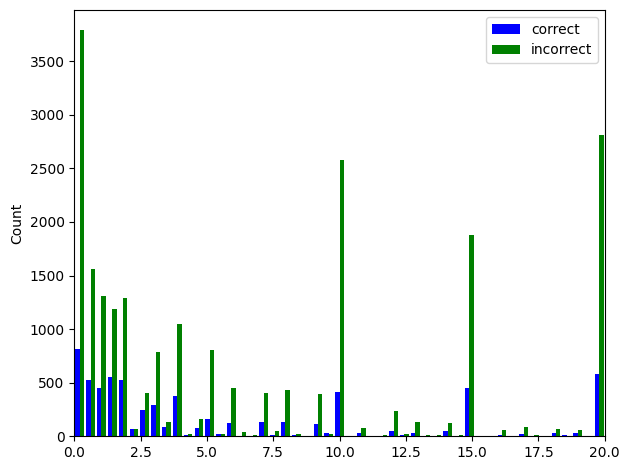

In [ ]:
length_vs_precision(df = data_pro[data_pro['hint_type'] == 'hint0'])

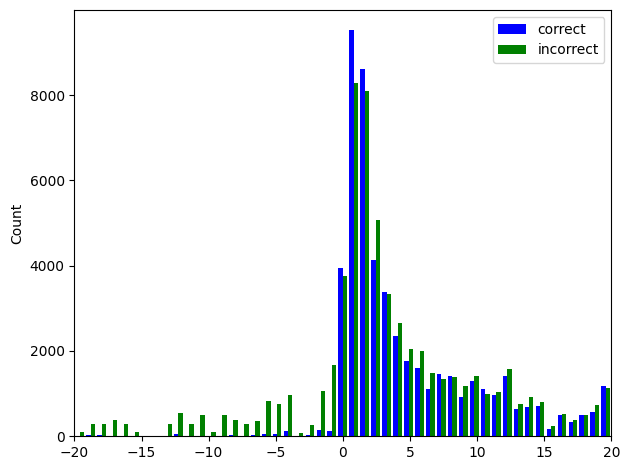

In [ ]:
scale_vs_precision(df = data_pro)

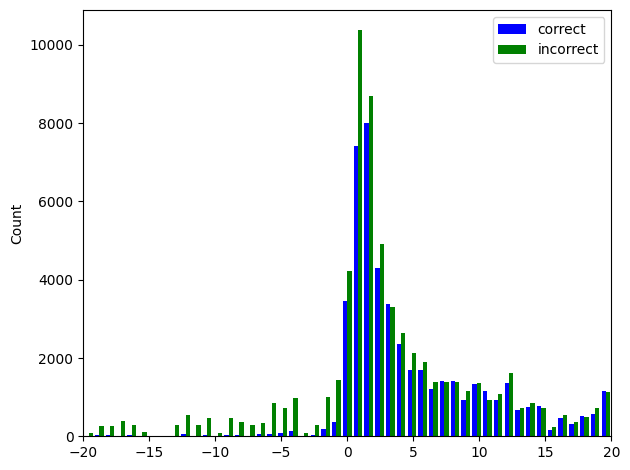

In [ ]:
scale_vs_precision(df = data_pro)

In [ ]:
length_vs_scale(df = data_pro)

{'len_scale_corr':               n         r        CI95%     p-val   BF10     power
 pearson  324031  0.000068  [-0.0, 0.0]  0.969185  0.002  0.050171}

## Reorganizing Paper tables

In [ ]:
import pandas as pd
def get_results():
    data = {
      "": ["", "dataset", "\multirow[t]{4}{*}{FinQA}", "", "", "", "\multirow[t]{4}{*}{Medical}", "", "", "", "\multirow[t]{4}{*}{MMLU}", "", "", ""],
      "": ["", "model", "\multirow[t]{2}{*}{gpt-3.5-turbo}", "", "\multirow[t]{2}{*}{gpt- 4o- mini}", "", "\multirow[t]{2}{*}{gpt - 3.5 - turbo}", "", "\multirow[t]{2}{*}{gpt - 4o - mini}", "", "\multirow[t]{2}{*}{gpt - 3.5 - turbo}", "", "\multirow[t]{2}{*}{gpt - 4o - mini}", ""],
      "": ["", "P.S.", "vanilla", "CoT", "vanilla", "CoT", "vanilla", "CoT", "vanilla", "CoT", "vanilla", "CoT", "vanilla", "CoT"],
      "\multicolumn{2}{r}{hit-avg}": ["mean", "", "6.47", "7.29", "18.29", "20.19", "48.31", "48.8 0", "60.3 0", "67.47", "59.35", "58.3 0", "68.04", "80.49"],
      "\multicolumn{2}{r}{hit@95\%}": ["std", "", "0.09", "0.17", "0.2 0", "0.12", "0.25", "0.38", "0.2 0", "0.29", "0.28", "0.44", "0.2 0", "0.31"],
      "\multicolumn{2}{r}{hit@90\%}": ["mean", "", "6.16", "7.04", "21.14", "21.54", "48.28", "48.48", "60.31", "68.49", "59.4 0", "57.68", "67.05", "79.56"],
      "\multicolumn{2}{r}{hit@60\%}": ["std", "", "0.24", "0.25", "0.35", "0.41", "0.59", "0.6 0", "0.55", "0.88", "0.62", "0.75", "0.64", "0.42"],
      "\multicolumn{2}{r}{hit@70\%}": ["mean", "", "5.5 0", "7.16", "18.95", "20.29", "47.71", "47.79", "60.41", "68. 00", "58.7 0", "57.2 0", "68.21", "80.07"],
      "\multicolumn{2}{r}{hit@80\%}": ["std", "", "0.23", "0.36", "0.41", "0.51", "0.59", "0.74", "0.42", "0.44", "0.65", "0.96", "0.63", "0.5 0"],
      "\multicolumn{2}{c}{corr}": ["mean", "", "7.42", "7.55", "17.04", "19.75", "49.42", "48.68", "60.39", "66.91", "60.03", "58.72", "68.85", "81.21"]
    }

    df = pd.DataFrame(data)
    return df

In [ ]:
get_results()

,,\multicolumn{2}{r}{hit-avg},\multicolumn{2}{r}{hit@95\%},\multicolumn{2}{r}{hit@90\%},\multicolumn{2}{r}{hit@60\%},\multicolumn{2}{r}{hit@70\%},\multicolumn{2}{r}{hit@80\%},\multicolumn{2}{c}{corr}
0,,mean,std,mean,std,mean,std,mean
1,P.S.,,,,,,,
2,vanilla,6.47,0.09,6.16,0.24,5.5 0,0.23,7.42
3,CoT,7.29,0.17,7.04,0.25,7.16,0.36,7.55
4,vanilla,18.29,0.2 0,21.14,0.35,18.95,0.41,17.04
5,CoT,20.19,0.12,21.54,0.41,20.29,0.51,19.75
6,vanilla,48.31,0.25,48.28,0.59,47.71,0.59,49.42
7,CoT,48.8 0,0.38,48.48,0.6 0,47.79,0.74,48.68
8,vanilla,60.3 0,0.2 0,60.31,0.55,60.41,0.42,60.39
9,CoT,67.47,0.29,68.49,0.88,68. 00,0.44,66.91


## Tests

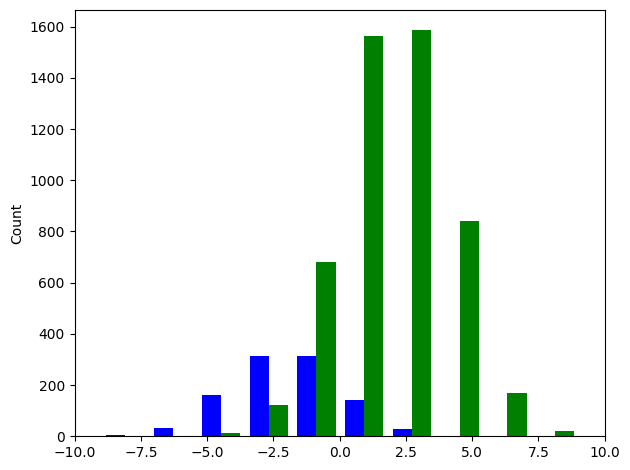

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#makes the data
y1 = np.random.normal(-2, 2, 1000)
y2 = np.random.normal(2, 2, 5000)
colors = ['b','g']

#plots the histogram
fig, ax1 = plt.subplots()
ax1.hist([y1,y2],color=colors)
ax1.set_xlim(-10,10)
ax1.set_ylabel("Count")
plt.tight_layout()
plt.show()